# YoloV3 TF2 GPU Colab Notebook

##### 1.  Clone and install dependencies 

**IMPORTANT**: Restart following the instruction

In [1]:
!git clone https://github.com/zzh8829/yolov3-tf2
%cd yolov3-tf2/
!pip install -r requirements-gpu.txt

Cloning into 'yolov3-tf2'...
remote: Enumerating objects: 341, done.
remote: Total 341 (delta 0), reused 0 (delta 0), pack-reused 341
Receiving objects: 100% (341/341), 4.16 MiB | 3.22 MiB/s, done.
Resolving deltas: 100% (198/198), done.
/content/yolov3-tf2
Obtaining file:///content/yolov3-tf2 (from -r requirements-gpu.txt (line 6))
     |████████████████████████████████| 421.8MB 24kB/s 
     |████████████████████████████████| 28.7MB 65kB/s 
     |████████████████████████████████| 450kB 40.8MB/s 
     |████████████████████████████████| 3.9MB 35.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=0c628c1c913b88ae5a03b9563c0412180c5e06094afe154b1b7a6796e68f568c
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc3 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorboard<2.3.

##### 2.  Check Tensorflow2 version

In [7]:
%cd yolov3-tf2/
!ls

import tensorflow as tf
tf.__version__

[Errno 2] No such file or directory: 'yolov3-tf2/'
/content/yolov3-tf2
checkpoints	 data		  README.md		train.py
colab_gpu.ipynb  detect.py	  requirements-gpu.txt	yolov3_tf2
conda-cpu.yml	 detect_video.py  requirements.txt	yolov3_tf2.egg-info
conda-gpu.yml	 docs		  setup.py
convert.py	 LICENSE	  tools


'2.1.0'

##### 3.  Convert Pretrained Darknet Weight

In [9]:
!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights
!python convert.py

--2020-04-19 16:14:39--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘data/yolov3.weights’

data/yolov3.weights 100%[===================>] 236.52M   833KB/s    in 5m 2s   

2020-04-19 16:19:41 (803 KB/s) - ‘data/yolov3.weights’ saved [248007048/248007048]

2020-04-19 16:19:44.845939: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-04-19 16:19:44.846100: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directo

In [4]:
!wget https://pjreddie.com/media/files/yolov3-tiny.weights -O data/yolov3-tiny.weights --no-check-certificate
!python convert.py --weights ./data/yolov3-tiny.weights --output ./checkpoints/yolov3-tiny.tf --tiny

--2020-04-19 16:00:31--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35434956 (34M) [application/octet-stream]
Saving to: ‘data/yolov3-tiny.weights’

data/yolov3-tiny.we 100%[===================>]  33.79M   710KB/s    in 52s     

2020-04-19 16:01:24 (664 KB/s) - ‘data/yolov3-tiny.weights’ saved [35434956/35434956]

2020-04-19 16:01:27.814588: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-04-19 16:01:27.814739: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file

##### 4. Initialize Detector

In [0]:
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs

flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

##### 4. Detect Image

I0419 16:21:30.388724 140229641119616 <ipython-input-12-5b956bc3b34a>:9] weights loaded
I0419 16:21:30.390059 140229641119616 <ipython-input-12-5b956bc3b34a>:12] classes loaded
I0419 16:21:30.773514 140229641119616 <ipython-input-12-5b956bc3b34a>:23] time: 0.30213332176208496
I0419 16:21:30.774542 140229641119616 <ipython-input-12-5b956bc3b34a>:25] detections:
I0419 16:21:30.782610 140229641119616 <ipython-input-12-5b956bc3b34a>:29] 	person, 0.9899101853370667, [0.7673807  0.59009314 0.9122138  0.8338851 ]
I0419 16:21:30.787864 140229641119616 <ipython-input-12-5b956bc3b34a>:29] 	laptop, 0.9890703558921814, [0.2925559  0.79342496 0.42100105 0.93220234]
I0419 16:21:30.792362 140229641119616 <ipython-input-12-5b956bc3b34a>:29] 	bottle, 0.9889384508132935, [0.6130664  0.70405966 0.6317627  0.7879459 ]
I0419 16:21:30.796985 140229641119616 <ipython-input-12-5b956bc3b34a>:29] 	person, 0.9883629679679871, [0.3436095  0.4572681  0.41140562 0.78335583]
I0419 16:21:30.800740 140229641119616 <ip

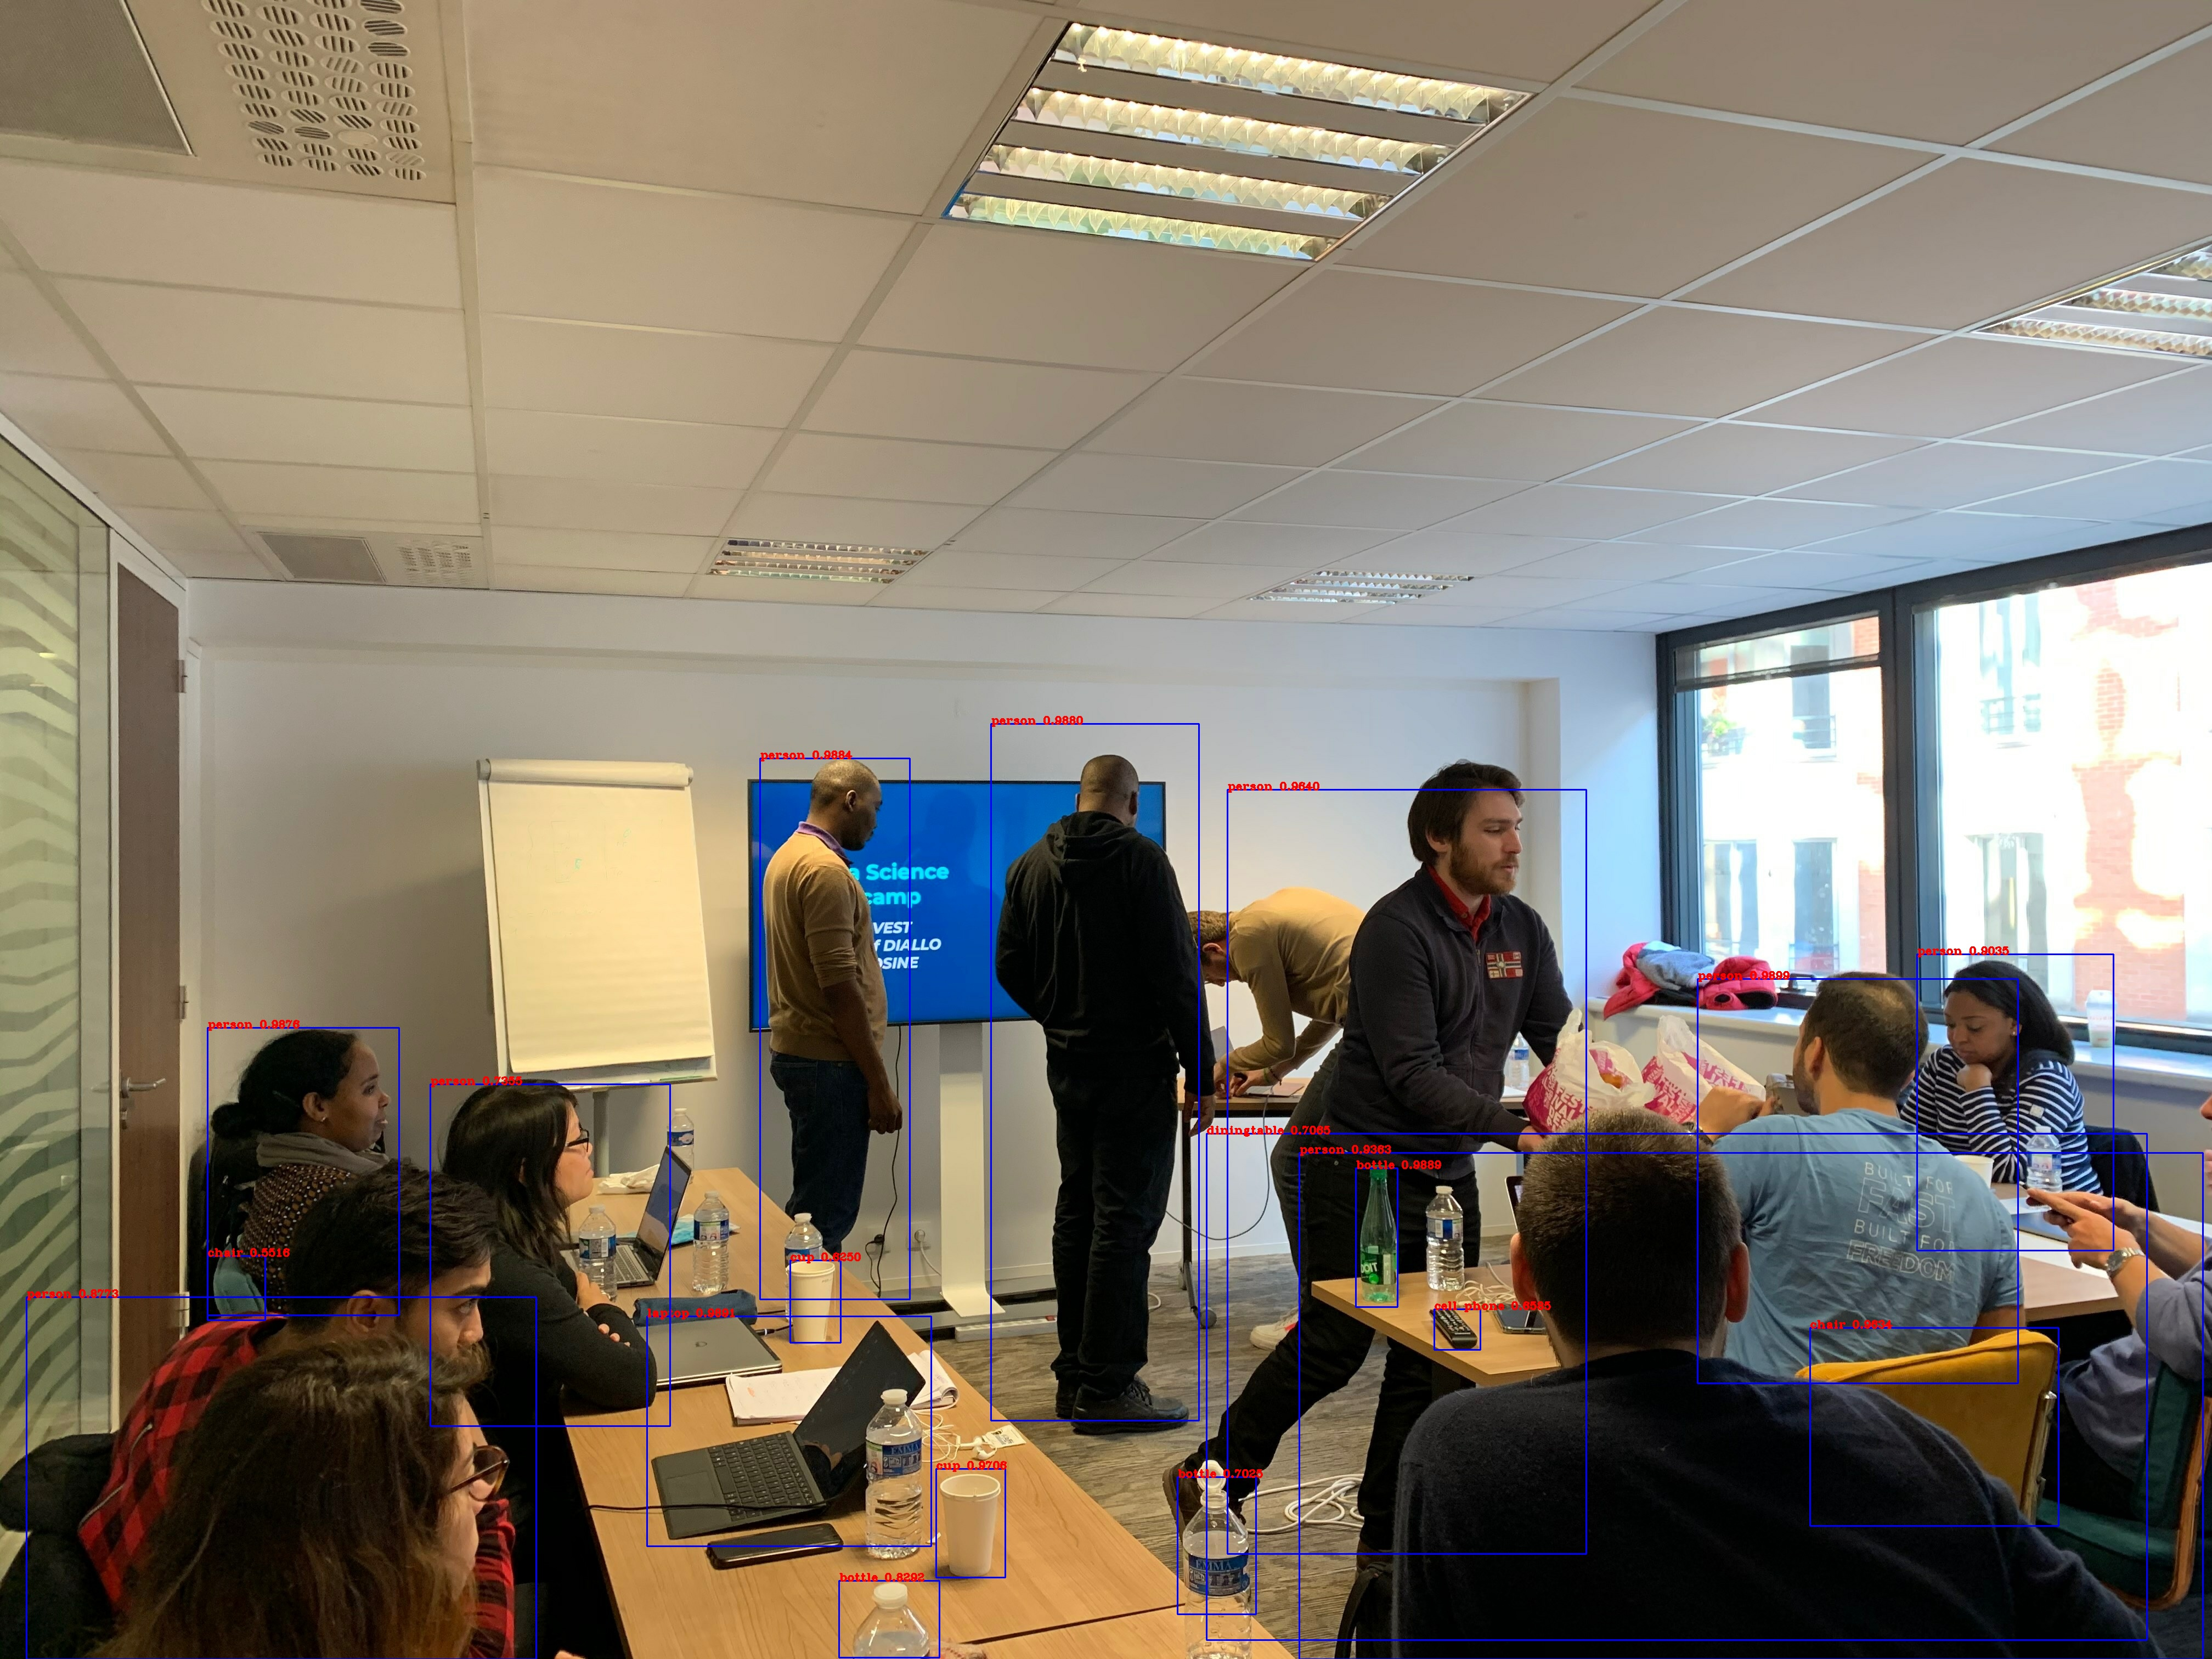

In [12]:
FLAGS.image = 'data/image.JPG'

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)
      
yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))

##### 5. Training New Dataset

In [13]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar -O ./data/voc2009_raw.tar
!mkdir -p ./data/voc2009_raw
!tar -xf ./data/voc2009_raw.tar -C ./data/voc2009_raw

--2020-04-19 16:27:21--  http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 935534080 (892M) [application/x-tar]
Saving to: ‘./data/voc2009_raw.tar’

./data/voc2009_raw. 100%[===================>] 892.19M  5.27MB/s    in 3m 5s   

2020-04-19 16:30:27 (4.82 MB/s) - ‘./data/voc2009_raw.tar’ saved [935534080/935534080]



In [14]:
!python tools/voc2012.py \
  --data_dir './data/voc2009_raw/VOCdevkit/VOC2009' \
  --split train \
  --output_file ./data/voc_train.tfrecord

!python tools/voc2012.py \
  --data_dir './data/voc2009_raw/VOCdevkit/VOC2009' \
  --split val \
  --output_file ./data/voc_val.tfrecord

2020-04-19 16:33:03.395369: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-04-19 16:33:03.395534: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-04-19 16:33:03.395562: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
I0419 16:33:04.486957 139814187878272 voc2012.py:92] Class mapping loaded: {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 1

In [15]:
!python tools/visualize_dataset.py --dataset ./data/voc_train.tfrecord --classes=./data/voc2012.names

2020-04-19 16:33:39.888382: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-04-19 16:33:39.888518: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-04-19 16:33:39.888550: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
I0419 16:33:40.957456 140539441559424 visualize_dataset.py:22] classes loaded
2020-04-19 16:33:41.043501: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because t

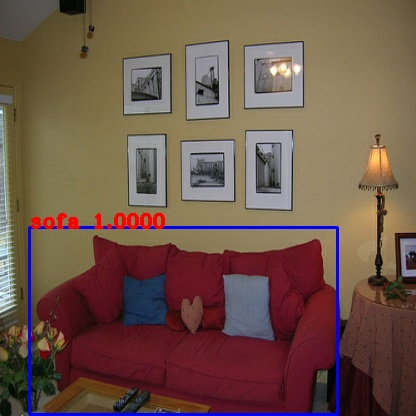

In [17]:
from IPython.display import Image
Image(filename='./output.jpg')

In [18]:
!python train.py \
	--dataset ./data/voc_train.tfrecord \
	--val_dataset ./data/voc_val.tfrecord \
	--classes ./data/voc2012.names \
	--num_classes 20 \
	--mode fit --transfer darknet \
	--batch_size 16 \
	--epochs 3 \
	--weights ./checkpoints/yolov3.tf \
	--weights_num_classes 80 

2020-04-19 16:34:33.953778: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-04-19 16:34:33.953897: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-04-19 16:34:33.953921: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Epoch 1/3
2020-04-19 16:35:08.030892: W tensorflow/core/common_runtime/bfc_allocator.cc:243] Allocator (GPU_0_bfc) ran out of memory trying to allocate 847.81MiB with freed_by_count=0. The caller indicates tha

##### 6. Detect using new weights

I0419 16:57:35.632731 140229641119616 <ipython-input-19-adb0b0e5a5ac>:16] weights loaded
I0419 16:57:35.634223 140229641119616 <ipython-input-19-adb0b0e5a5ac>:19] classes loaded
I0419 16:57:36.021927 140229641119616 <ipython-input-19-adb0b0e5a5ac>:30] time: 0.3029935359954834
I0419 16:57:36.023251 140229641119616 <ipython-input-19-adb0b0e5a5ac>:32] detections:
I0419 16:57:36.031505 140229641119616 <ipython-input-19-adb0b0e5a5ac>:36] 	person, 0.20205923914909363, [0.33730504 0.46437213 0.4167218  0.78941154]


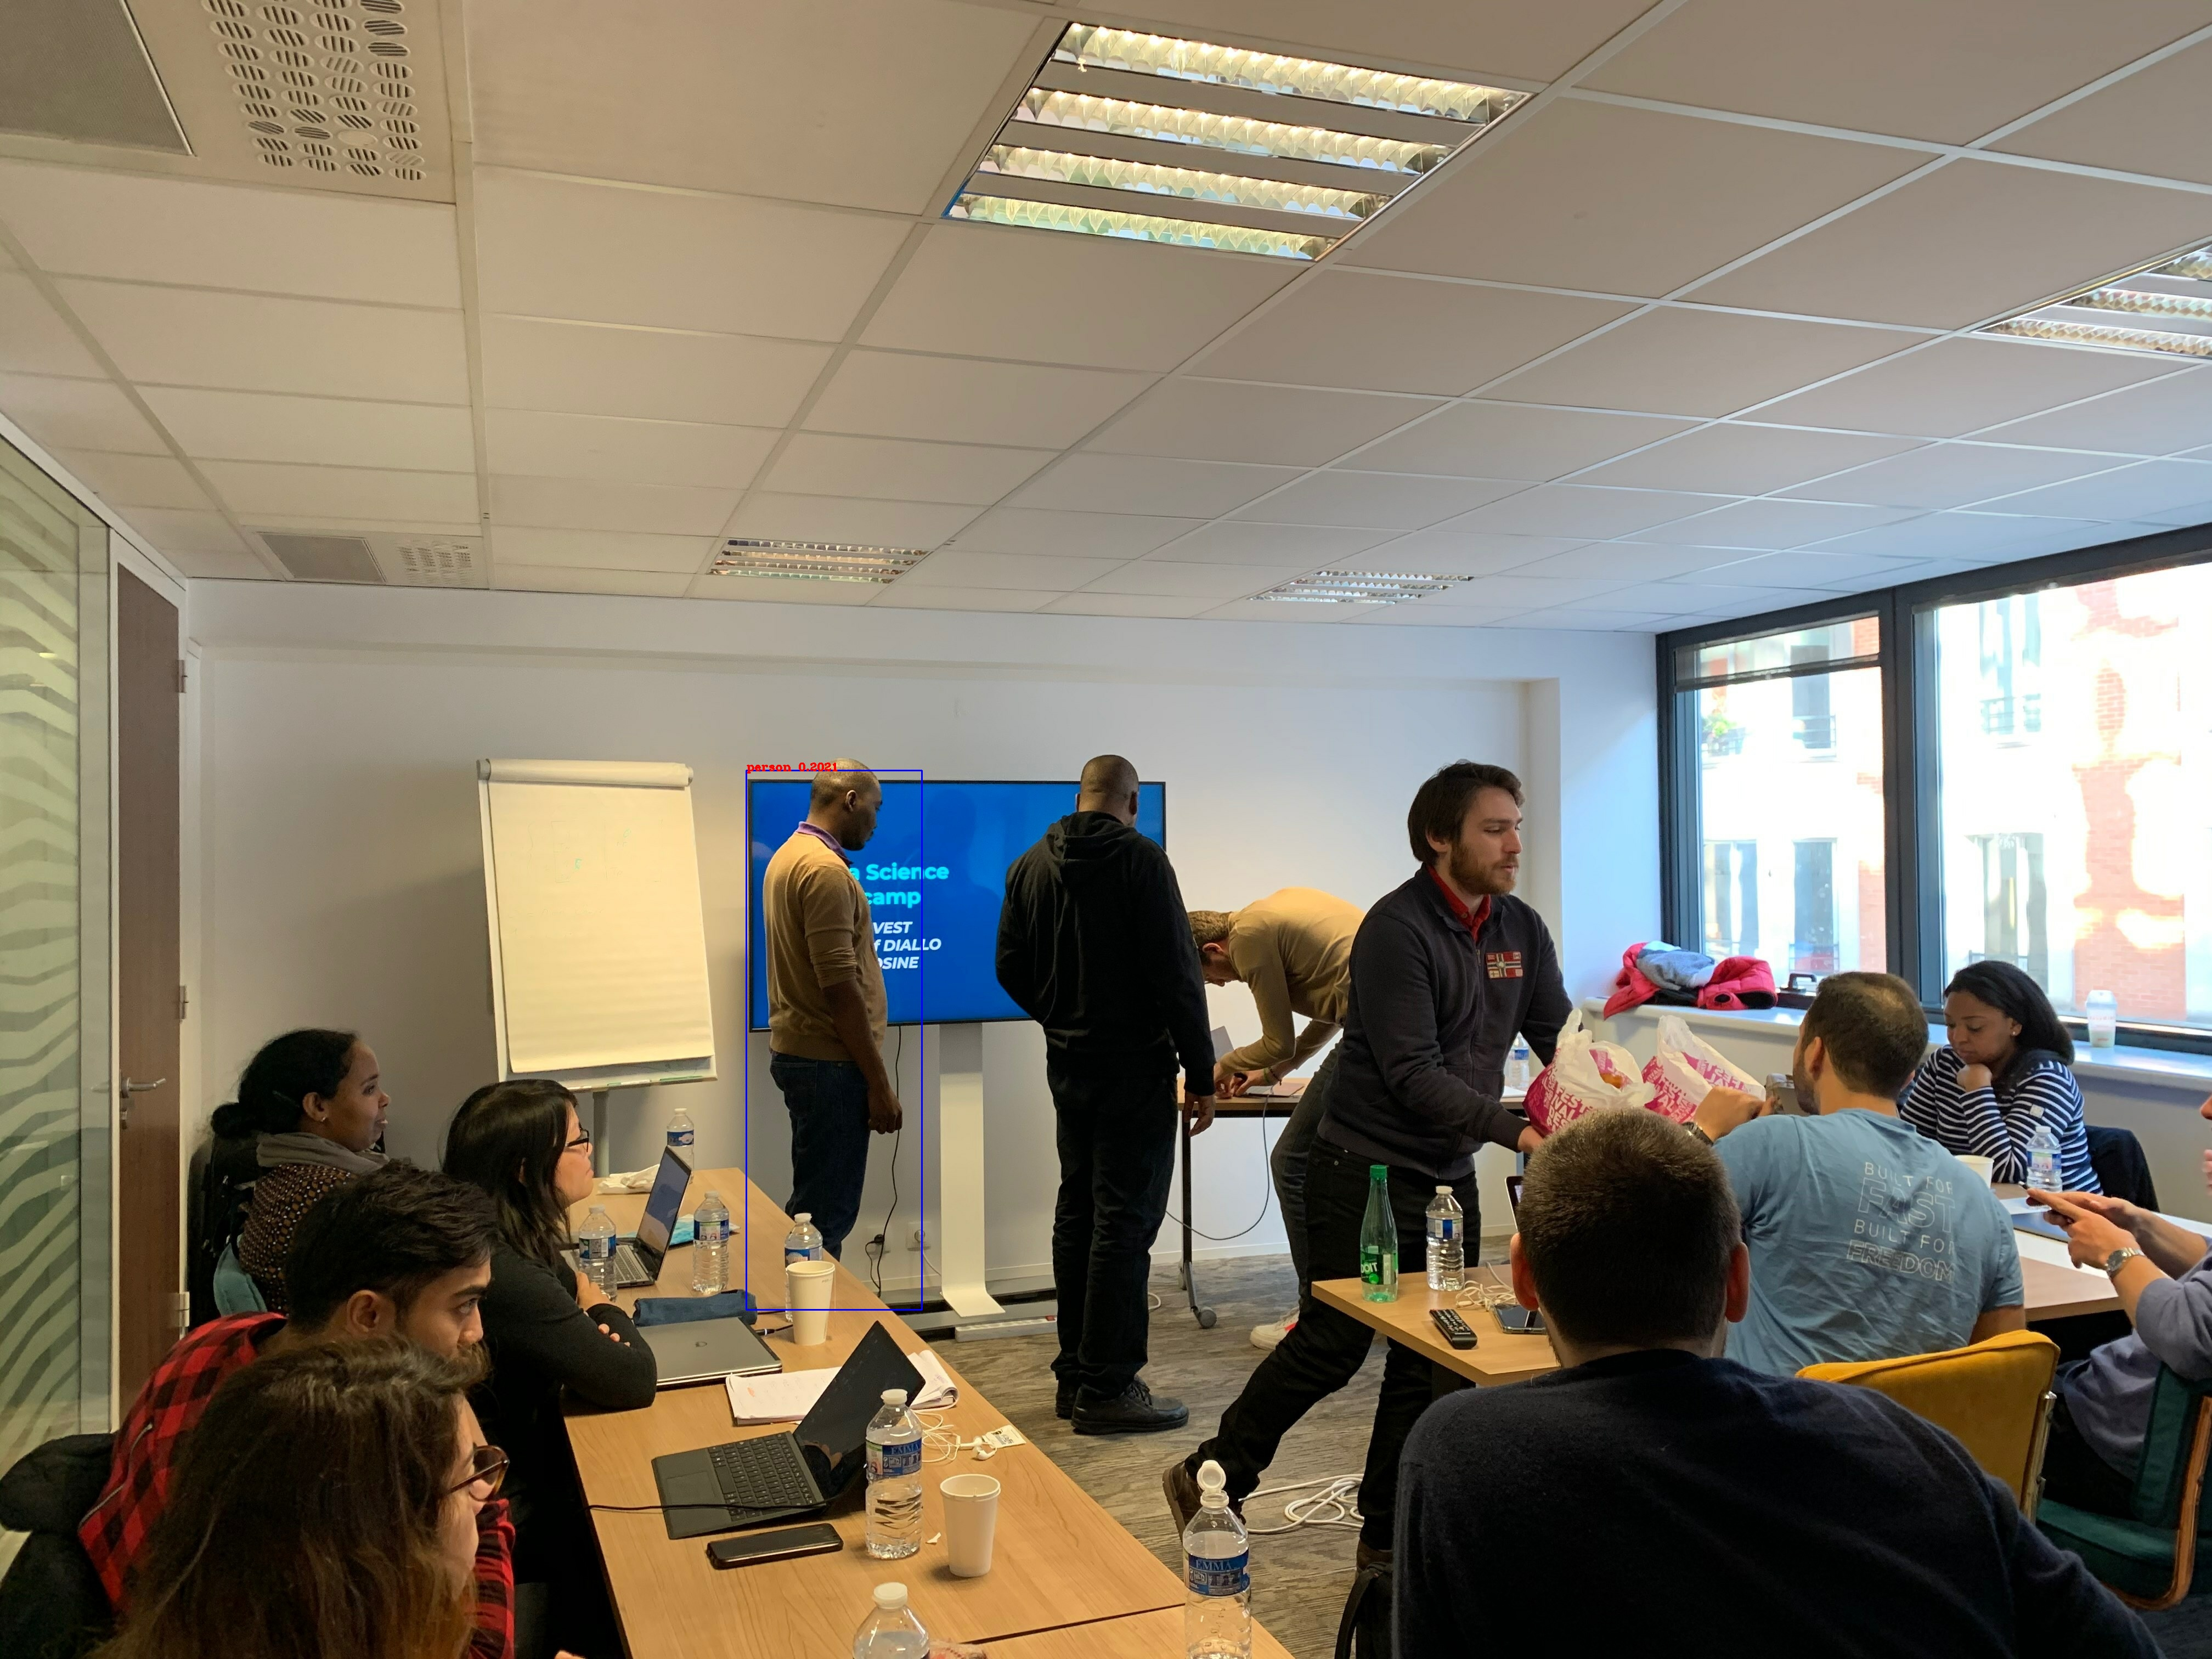

In [19]:
FLAGS.num_classes = 20
FLAGS.classes = 'data/voc2012.names'
FLAGS.weights = 'checkpoints/yolov3_train_3.tf'
FLAGS.image = 'data/image.JPG'

# Lower threshold due to insufficient training
FLAGS.yolo_iou_threshold = 0.2
FLAGS.yolo_score_threshold = 0.2

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))